In [323]:
import requests
from io import StringIO
import pandas as pd
from datetime import datetime, timedelta 
from talib import abstract
import numpy as np
import pandas as pd
import talib


def parse_ymd(s):
    year_s, mon_s, day_s = s.split('/')
    return datetime(int(year_s), int(mon_s), int(day_s))

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (80,20)

def plot_candles(start_time, end_time, pricing, title=None,
                 volume_bars=False,
                 color_function=None,
                 overlays=None,
                 overlays_name=None,
                 technicals=None,
                 technicals_titles=None,image_name=None):
    """ Plots a candlestick chart using quantopian pricing data.
    
    Author: Daniel Treiman
    
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      overlays: A list of additional data series to overlay on top of pricing.  Must be the same length as pricing.
      technicals: A list of additional data series to display as subplots.
      technicals_titles: A list of titles to display for each technical indicator.
    """
    
    pricing = pricing[start_time:end_time]
    if overlays is not None:
        overlays = [o[start_time:end_time] for o in overlays]
    if technicals is not None:
        technicals = [t[start_time:end_time] for t in technicals]
    
    def default_color(index, open_price, close_price, low, high):
        return 'g' if open_price[index] > close_price[index] else 'r'
    color_function = color_function or default_color
    overlays = overlays or []
    overlays_name= overlays_name or []
    technicals = technicals or []
    technicals_titles = technicals_titles or []
    image_name = image_name or 'lines'
    open_price = pricing['open']
    close_price = pricing['close']
    low = pricing['low']
    high = pricing['high']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    
    subplot_count = 1
    if volume_bars:
        subplot_count = 2
    if technicals:
        subplot_count += len(technicals)
    
    if subplot_count == 1:
        fig, ax1 = plt.subplots(1, 1)
    else:
        ratios = np.insert(np.full(subplot_count - 1, 1), 0, 3)
        fig, subplots = plt.subplots(subplot_count, 1, sharex=True, gridspec_kw={'height_ratios': ratios})
        ax1 = subplots[0]
        
    if title:
        ax1.set_title(title)
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x , low, high, color=candle_colors, linewidth=1)#+ 0.4
    ax1.xaxis.grid(False)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%d-%m-%Y'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    ticks = [date.strftime(time_format) for date in pricing.index]
    space = max(int(len(ticks) / 100), 1)
    
    for i, t in enumerate(ticks):
        ticks[i] = t if i%space == 0 or i == len(ticks) - 1 else ''
        
    plt.xticks(x, ticks, rotation='vertical')
    for overlay, overlays_name in zip(overlays,overlays_name):
        ax1.plot(x, overlay,label=overlays_name)
    fig.legend(prop={'size': 50})
    fig.savefig(image_name)
    # Plot volume bars if needed
    if volume_bars:
        ax2 = subplots[1]
        volume = pricing['volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        ax2.xaxis.grid(False)
    # Plot additional technical indicators
    for (i, technical) in enumerate(technicals):
        ax = subplots[i - len(technicals)] # Technical indicator plots are shown last
        ax.plot(x, technical)
        if i < len(technicals_titles):
            ax.set_title(technicals_titles[i])

def getline(df):
    SMA30 = abstract.SMA(df,timeperiod=30)
    SMA72 = abstract.SMA(df,timeperiod=72)
    SUMAVG = (SMA30 + SMA72)/2
    SUMAVG_P_10 = SUMAVG+10
    SUMAVG_S_10 = SUMAVG-10
    SUMAVG_P_20 = SUMAVG+20
    SUMAVG_S_20 = SUMAVG-20
    RSI = abstract.RSI(df)
    STOCH = abstract.STOCH(df)
    name = ['SMA30','SMA72','SUMAVG','SUMAVG_P_10','SUMAVG_S_10','SUMAVG_P_20','SUMAVG_S_20']

    plot_candles(
                 # 起始時間、結束時間
                 start_time=df.index[0].strftime('%Y-%m-%d'),
                 end_time=df.index[-1].strftime('%Y-%m-%d'),

                 # 股票的資料
                 pricing=df, 
                 title='Candles',
                 # 是否畫出成交量？
                 #volume_bars=True, 

                 # 將某些指標（如SMA）跟 K 線圖畫在一起
                 overlays=[SMA30,SMA72,SUMAVG,SUMAVG_P_10,SUMAVG_S_10,SUMAVG_P_20,SUMAVG_S_20], 
                 overlays_name = name,
                 image_name = df.index[0].strftime('%Y-%m-%d') + 'to' + df.index[-1].strftime('%Y-%m-%d') + 'lines'

                 # 將某些指標（如RSI, STOCH）單獨畫在獨立的畫格中
                 #technicals = [RSI, STOCH],

                 # 重新命名額外的畫格名稱（跟指標名稱一樣就可以囉！）
                 #technicals_titles=['RSI', 'KD']
                )

In [170]:

df_final

,2,3,4,5,6,7,8,9,10,11,12,13
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:

import datetime
time_y = int(datetime.datetime.now().strftime("%Y"))
time_m = int(datetime.datetime.now().strftime("%m"))
time_d = int(datetime.datetime.now().strftime("%d"))
time_f = datetime.datetime.now().strftime("%Y%m%d")
df_final = pd.DataFrame(columns=[2,3,4,5,6,7,8,9,10,11,12,13])
for i in range(7):
    if time_d-i <=0:
        time_d = 30+(time_d-i)
        Day = str(time_d)
        time_m = time_m-1
        if time_m-1<=0:
            time_y = time_y-1
    if time_d-i <10:
        Day='0'+str(time_d-i)
    else:
        Day=str(time_d-i)
    if time_m <10:
        Mounth='0'+str(time_m)
    else:
        Mounth=str(time_m)
    payload ={
    'queryType': '1',
    'doQuery': '1',
    'queryDate': str(time_y)+"/"+str(Mounth)+"/"+str(Day),
    }
    #print(payload)
    r = requests.post('https://www.taifex.com.tw/cht/3/futAndOptDate' , data = payload)
    r.encoding = 'utf-8'
    dfs = pd.read_html(StringIO(r.text))
    try:
        dfs[5:6][0].columns = ['']*len(dfs[5:6][0].columns)
        df = dfs[5:6][0][2:3]
        #print(df)
        
        df.columns=[1,2,3,4,5,6,7,8,9,10,11,12,13]
        df[14] = str(y)+'/'+Mounth+'/'+str(Day)
        df1 = df[[2,3,4,5,6,7,8,9,10,11,12,13,14]]
        df1 = df1.set_index(14)
        #print(df1)
        df_final = df_final.append(df1)
    except:
        pass
df_final = df_final.iloc[::-1]
df_final.to_csv(time_f+'.csv')A

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2]:
payload ={
'code': '8436',
'ctl00$ContentPlaceHolder1$startText': '2008/01/02',
'ctl00$ContentPlaceHolder1$endText': '2020/03/17',
'ctl00$ContentPlaceHolder1$submitBut': '查詢',
}


In [239]:
r = requests.post('https://www.cnyes.com/twstock/ps_historyprice/2337.html' , data = payload)

r.encoding = 'utf-8'
# 把剛剛下載下來的網頁的 html 文字檔，利用 StringIO() 包裝成一個檔案給 pandas 讀取
dfs = pd.read_html(StringIO(r.text))

dfs2 = dfs[0].iloc[::-1]

dfs2['日期'] = dfs2['日期'].map(lambda x:parse_ymd(x))

dfs2.rename(columns={'日期':'date','收盤':'close', '開盤':'open', '最高':'high', '最低':'low', '成交量':'volume'}, inplace=True)

dfs2 = dfs2.drop(['漲跌','漲%','成交金額','本益比'],axis=1)

dfs2 = dfs2.set_index('date')

df = dfs2

one_year = (df.index[-1] - timedelta(days=365+1)).strftime('%Y-%m-%d')

half_year = (df.index[-1] - timedelta(days=(365/2)+1)).strftime('%Y-%m-%d')

df_one_year = df[one_year:]

df_half_year = df[half_year:]

In [7]:
getline(df)
getline(df_one_year)
getline(df_half_year)

'2018-05-19'

In [282]:
dfs2

,open,high,low,close,volume
date,,,,,
2008-01-03,14.50,14.60,14.25,14.50,23893
2008-01-04,14.50,15.00,14.30,14.30,48079
2008-01-07,13.60,13.80,13.30,13.30,25927
2008-01-08,13.40,13.65,13.10,13.15,21154
2008-01-09,12.85,13.65,12.75,13.65,23701
...,...,...,...,...,...
2020-03-11,34.80,35.05,33.15,33.40,46882
2020-03-12,32.95,32.95,30.25,30.65,77115
2020-03-13,27.70,29.55,27.60,29.10,80694


In [349]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,20

In [372]:
#df['close']
#台指期的話使用此程式
df = world_index_history['TSEC weighted index']['2008-01':][['Adj Close','Volume']]
df = df.rename(columns={"Adj Close": "close", "Volume": "volume"}, index={'Date': 'date'})
df['open'] = 0
df['high'] = 0
df['low'] = 0
df = df.dropna()

In [373]:
df.loc['2008-07']['close']

Date
2008-07-01    7407.952148
2008-07-02    7353.832031
2008-07-03    7394.072266
2008-07-04    7228.382813
2008-07-07    7341.082031
2008-07-08    7051.824219
2008-07-09    7048.224121
2008-07-10    7075.623535
2008-07-11    7244.732422
2008-07-14    7156.933105
2008-07-15    6834.214355
2008-07-16    6710.614258
2008-07-17    6974.483887
2008-07-18    6815.293945
2008-07-21    7085.643555
2008-07-22    7065.624023
2008-07-23    7309.802246
2008-07-24    7368.052246
2008-07-25    7233.592773
2008-07-29    7014.444336
2008-07-30    7070.324219
2008-07-31    7024.034180
Name: close, dtype: float64

In [377]:
three = abstract.SMA(df,timeperiod=3)

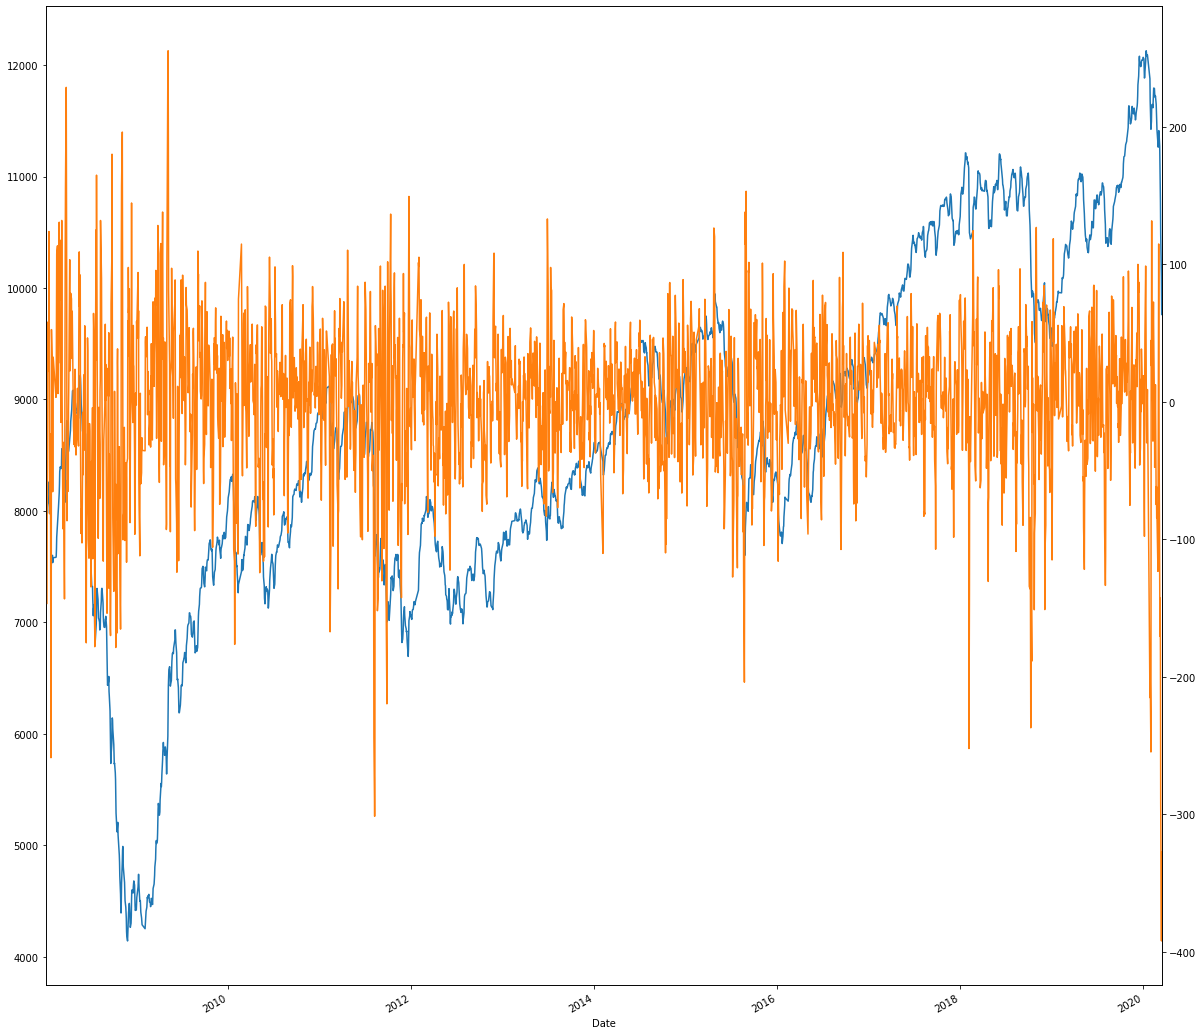

In [382]:
three.plot()
three_Slope = three.diff()
three_Slope.plot(secondary_y=True)

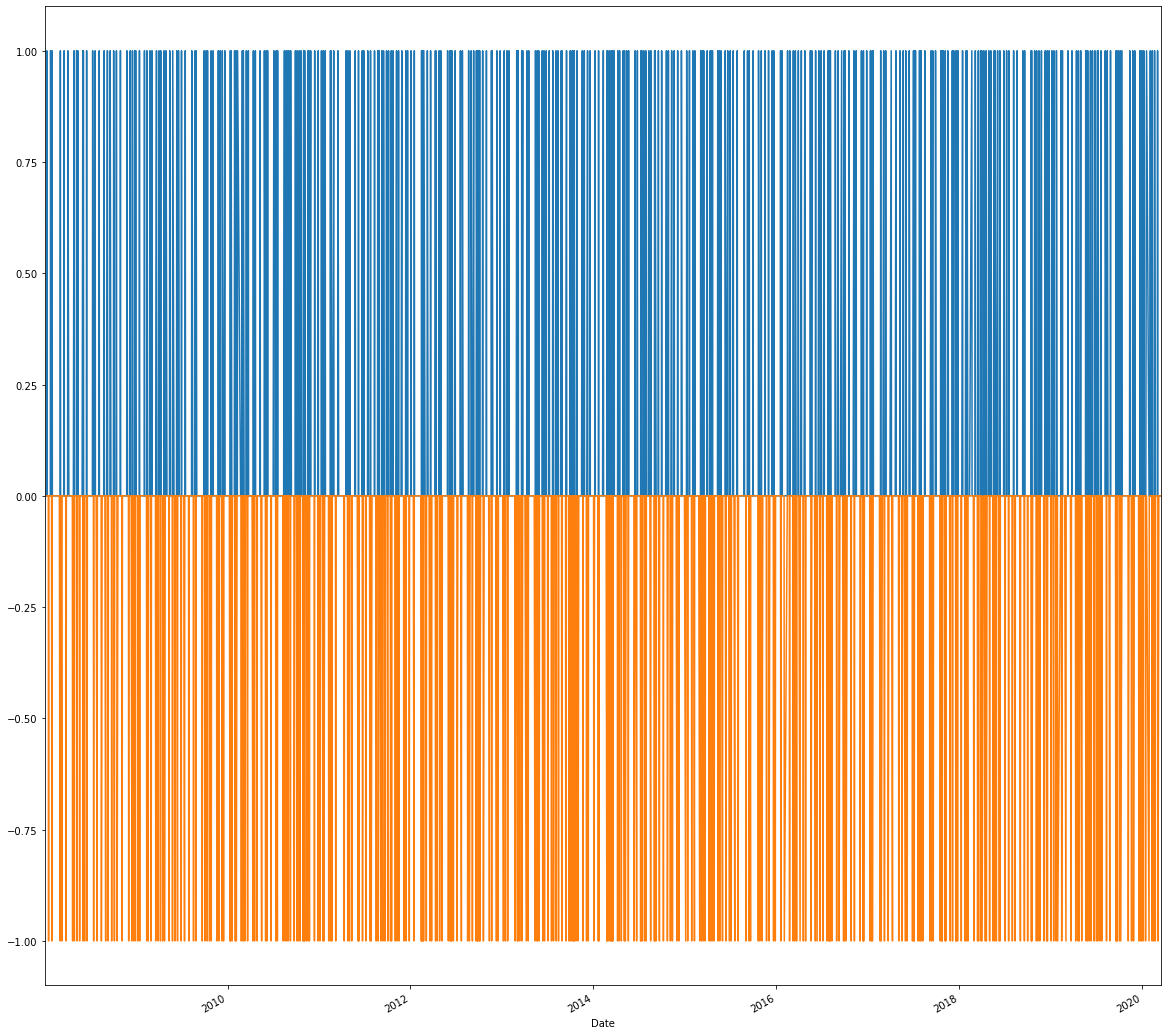

In [383]:
buy_three = (three_Slope > 0) & (three_Slope.shift() < 0)
sell_three = (three_Slope < 0) & (three_Slope.shift() > 0)

(buy_three * 1).plot()
(sell_three * -1).plot()

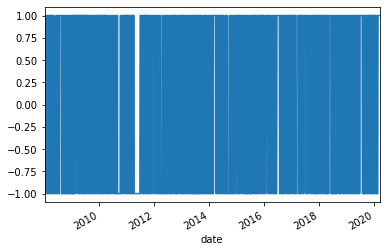

In [10]:
import numpy as np
hold = pd.Series(np.nan, index=buy_three.index)
hold[buy_three] = 1
hold[sell_three] = -1
hold.ffill(inplace=True)
hold.plot()

In [384]:
eighteen = abstract.SMA(df,timeperiod=18).dropna()

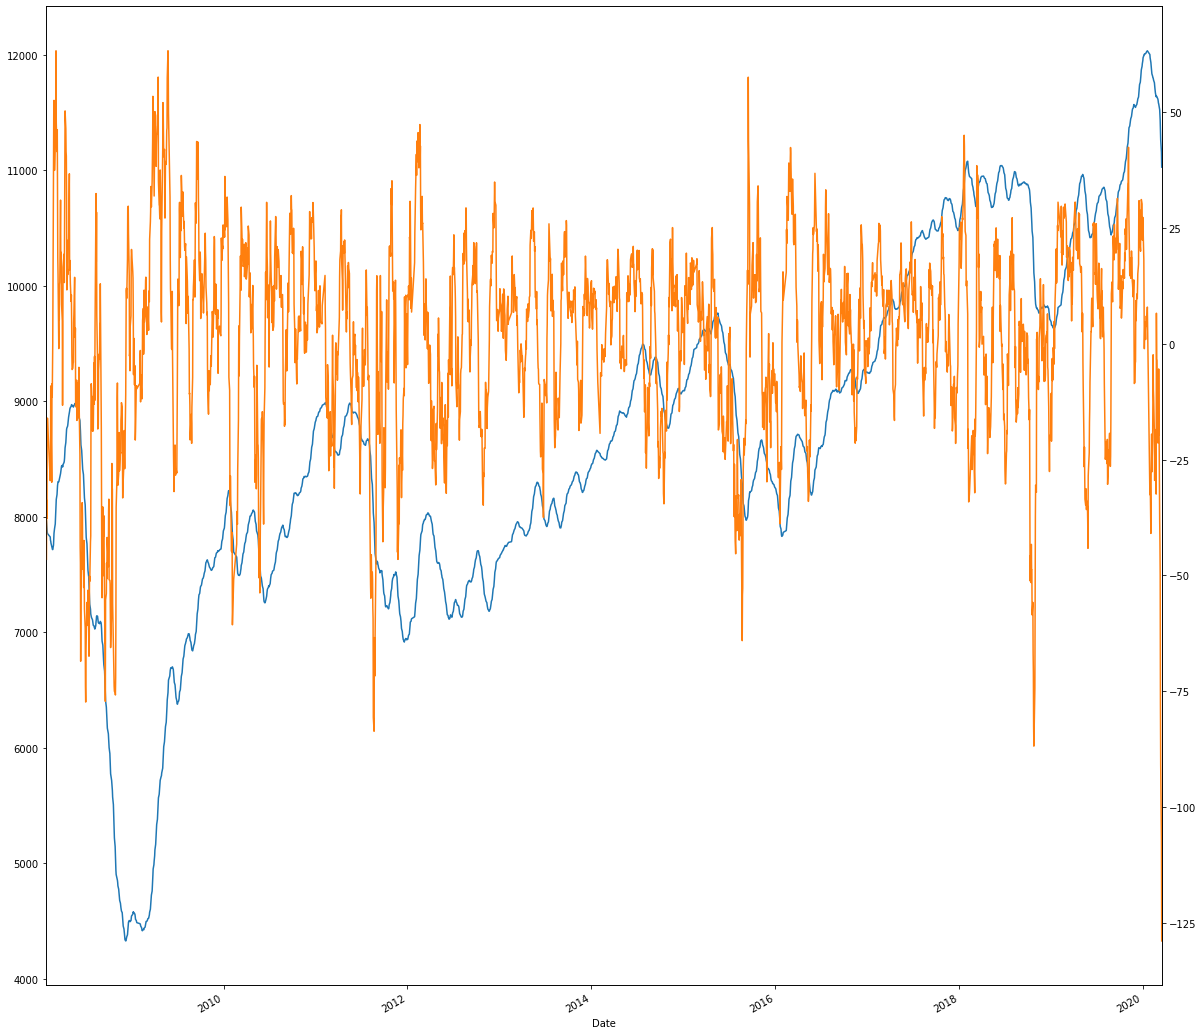

In [385]:
eighteen.plot()
eighteen_Slope = eighteen.diff()
eighteen_Slope.plot(secondary_y=True)

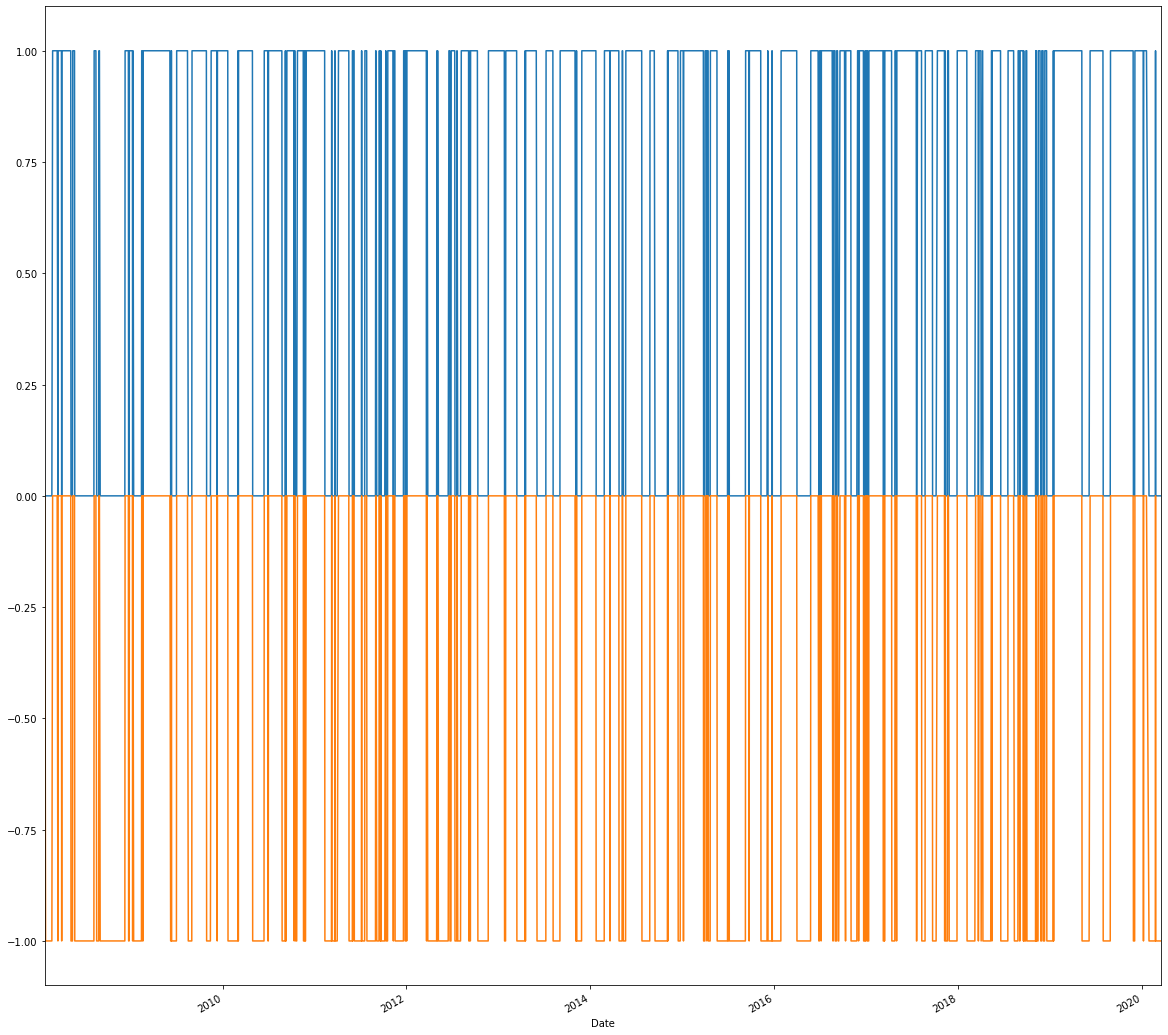

In [386]:
buy_eighteen = (eighteen_Slope > 0)
sell_eighteen = (eighteen_Slope < 0)

(buy_eighteen * 1).plot()
(sell_eighteen * -1).plot()

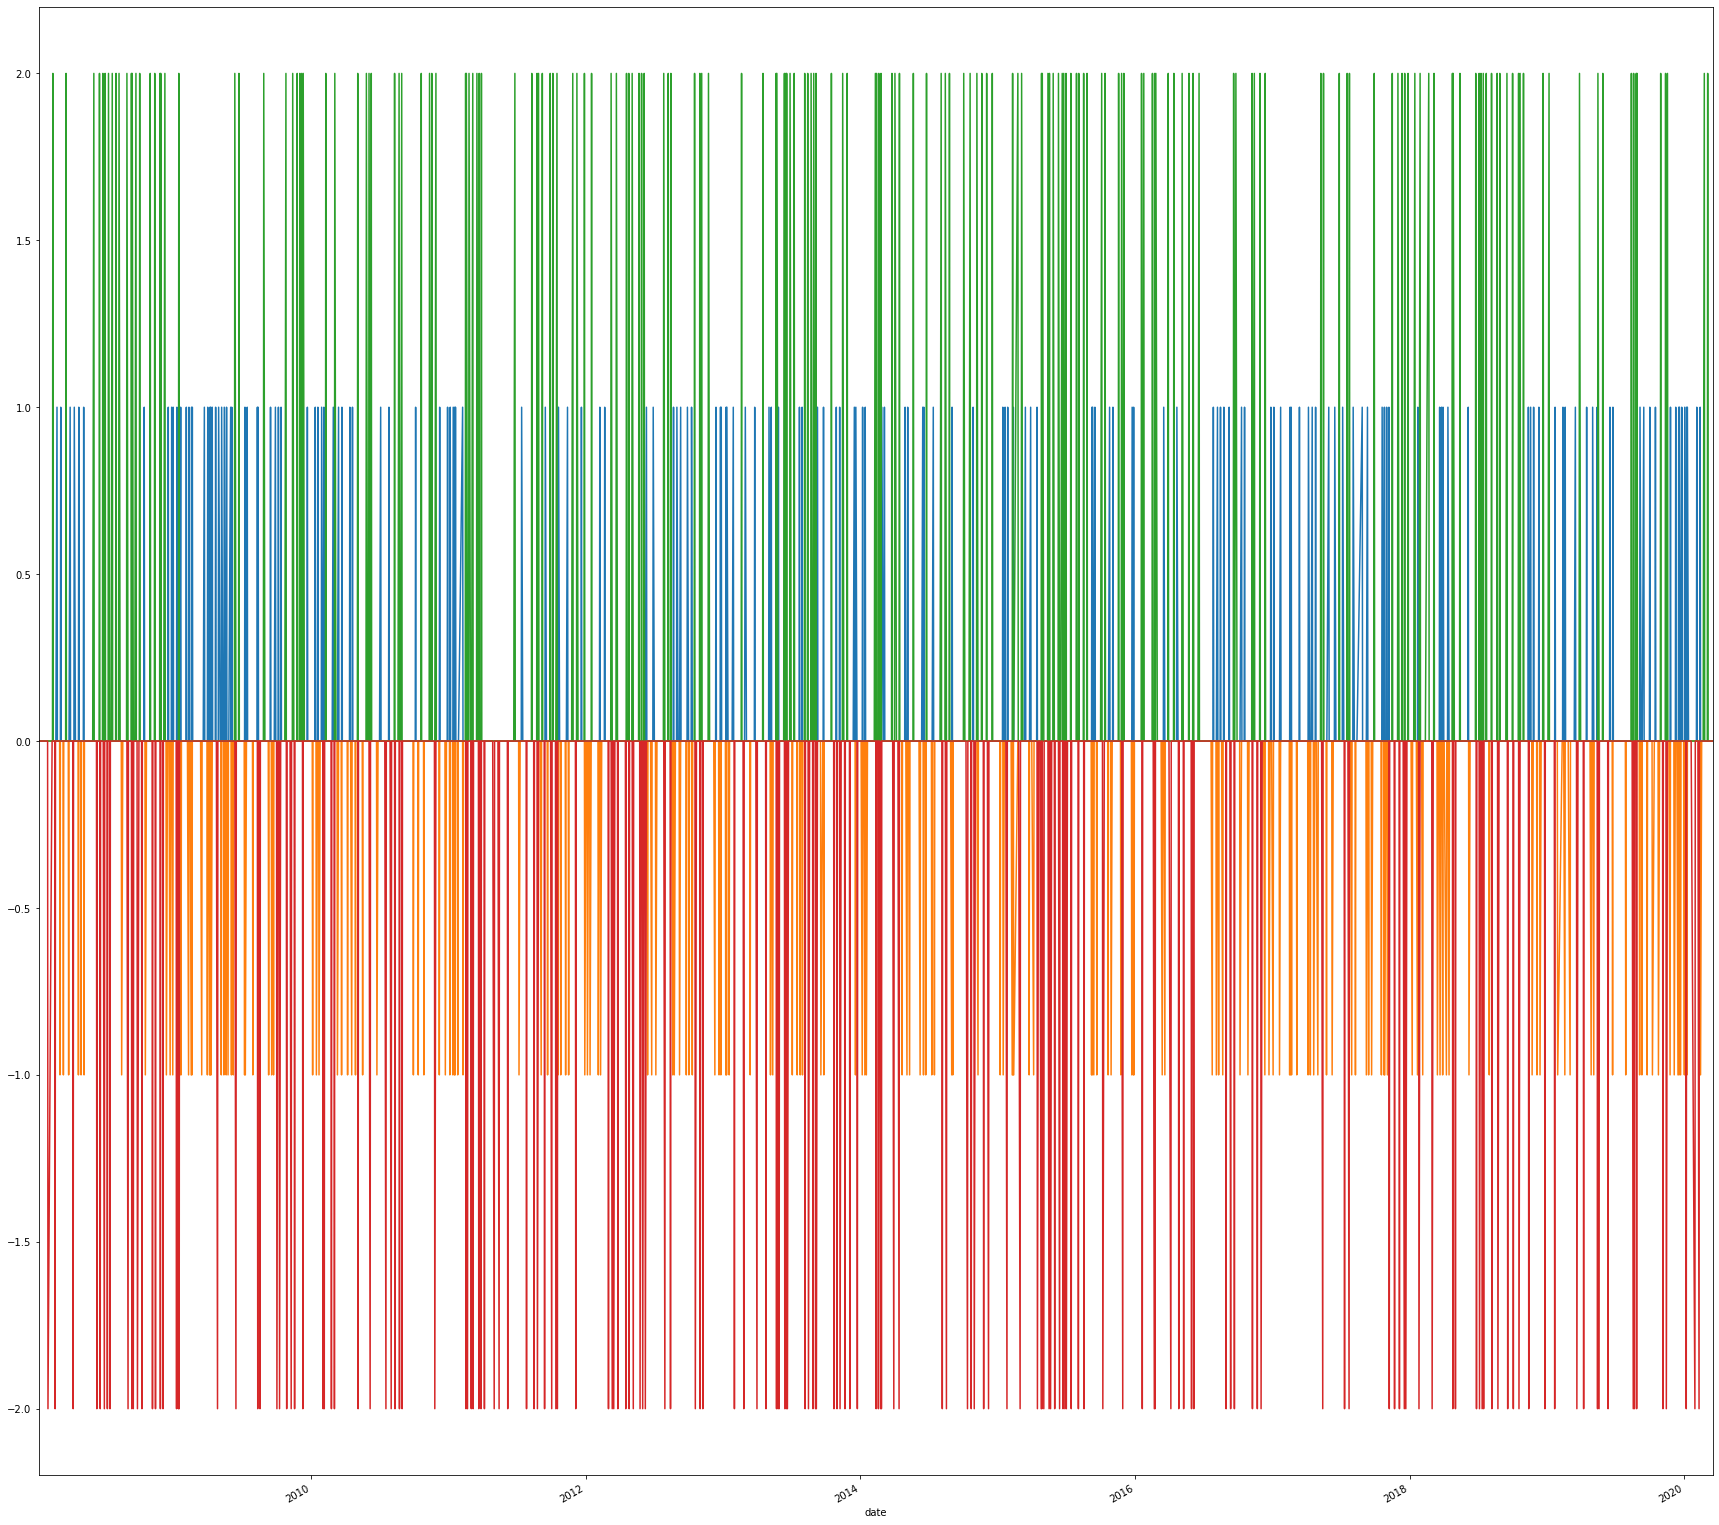

In [25]:
buy = (three_Slope > 0) & (three_Slope.shift() < 0) & (eighteen_Slope > 0)
sell_ne = (three_Slope < 0) & (three_Slope.shift() > 0) & (eighteen_Slope > 0)
fill_e = (three_Slope > 0) & (three_Slope.shift() < 0) & (eighteen_Slope < 0)
sell_e = (three_Slope < 0) & (three_Slope.shift() > 0) & (eighteen_Slope < 0)

(buy * 1).plot()
(sell_ne * -1).plot()
(fill_e * 2).plot()
(sell_e * -2).plot()

In [387]:
six = abstract.SMA(df,timeperiod=6).dropna()

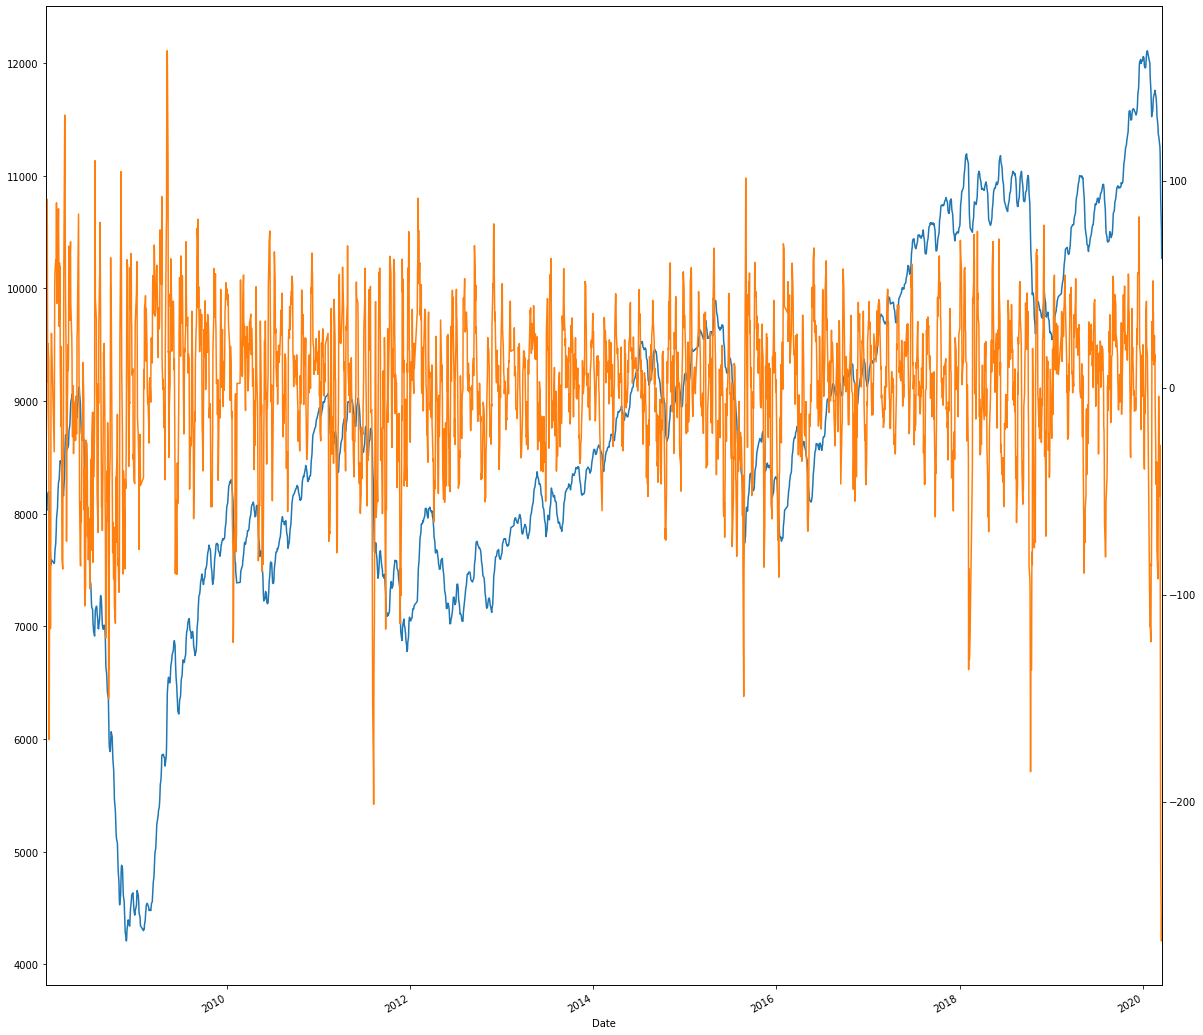

In [388]:
six.plot()
six_Slope = six.diff()
six_Slope.plot(secondary_y=True)

In [389]:
buy = pd.Series(index=df.index.copy())
sell = pd.Series(index=df.index.copy())

In [390]:
#3日線 負轉正 & 6正 & 18正
for k,v in (((three_Slope > 0) & (three_Slope.shift() < 0)) & ((six_Slope > 0) & (eighteen_Slope > 0))).items():
    if v == True:
        print(k)
        buy[k] = True

2008-03-04 00:00:00
2008-04-28 00:00:00
2008-12-17 00:00:00
2008-12-30 00:00:00
2009-02-13 00:00:00
2009-02-25 00:00:00
2009-03-05 00:00:00
2009-03-23 00:00:00
2009-04-02 00:00:00
2009-04-09 00:00:00
2009-04-30 00:00:00
2009-05-27 00:00:00
2009-07-16 00:00:00
2009-10-07 00:00:00
2009-10-13 00:00:00
2009-11-25 00:00:00
2009-12-11 00:00:00
2010-01-12 00:00:00
2010-01-15 00:00:00
2010-03-05 00:00:00
2010-03-17 00:00:00
2010-04-14 00:00:00
2010-07-14 00:00:00
2010-07-20 00:00:00
2010-08-23 00:00:00
2010-09-29 00:00:00
2010-10-06 00:00:00
2010-11-01 00:00:00
2010-11-05 00:00:00
2010-11-22 00:00:00
2010-11-29 00:00:00
2010-12-15 00:00:00
2010-12-29 00:00:00
2011-01-18 00:00:00
2011-01-26 00:00:00
2011-04-20 00:00:00
2011-04-27 00:00:00
2011-05-05 00:00:00
2011-07-26 00:00:00
2011-09-16 00:00:00
2011-10-24 00:00:00
2011-11-07 00:00:00
2011-12-21 00:00:00
2012-01-17 00:00:00
2012-02-15 00:00:00
2012-02-21 00:00:00
2012-02-24 00:00:00
2012-05-02 00:00:00
2012-08-21 00:00:00
2012-09-10 00:00:00


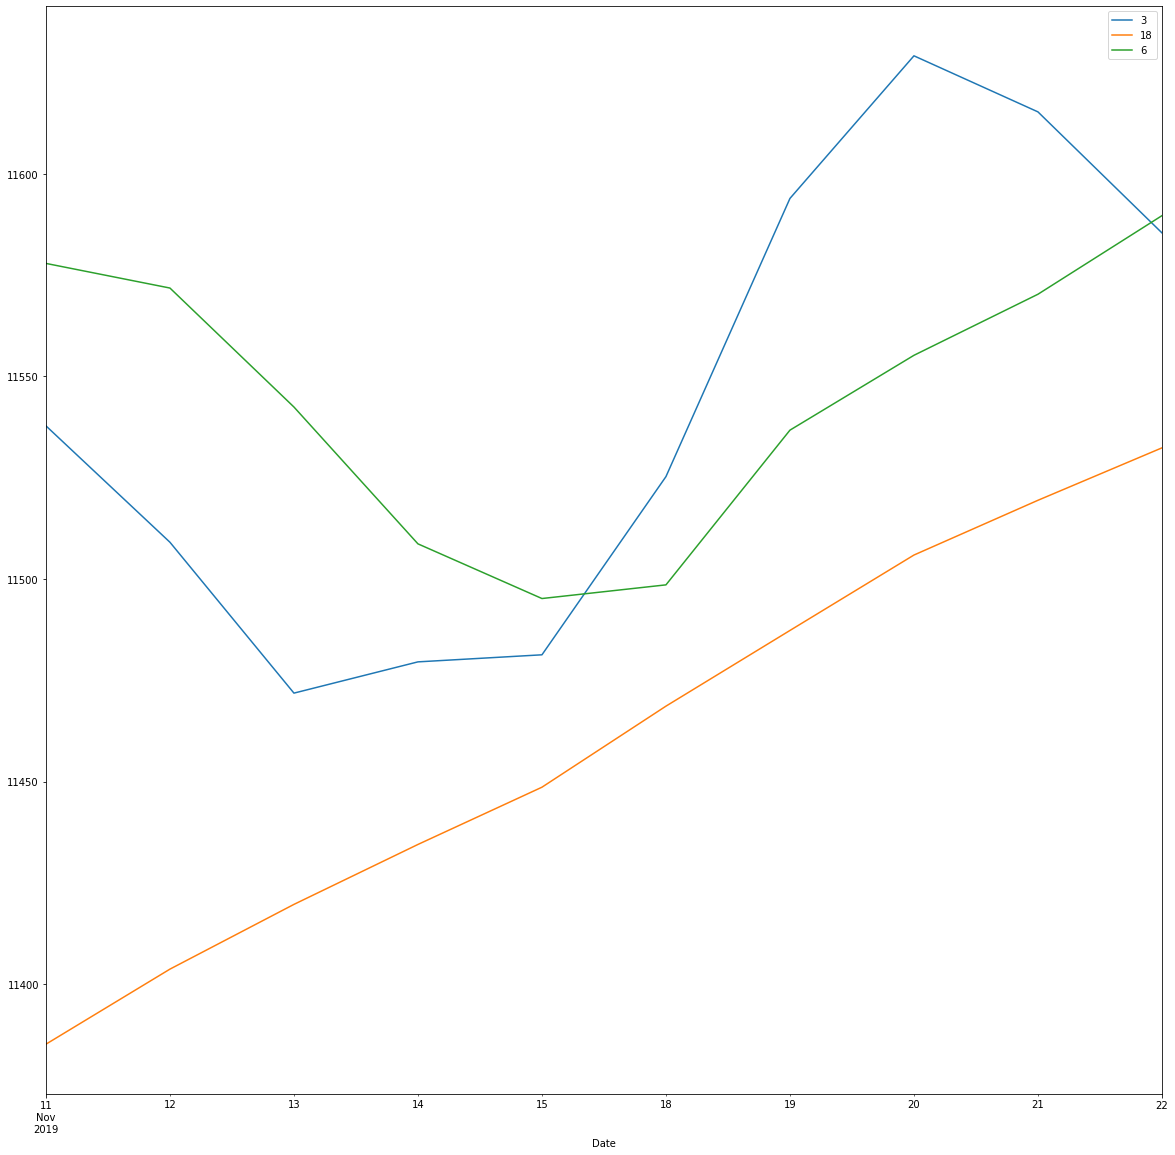

In [391]:
three['2019-11-10':'2019-11-23'].plot(label='3')
eighteen['2019-11-10':'2019-11-23'].plot(label='18')
six['2019-11-10':'2019-11-23'].plot(label='6')
plt.legend()

In [392]:
#3日線 負轉正 & 6正 & 18負
for k,v in (((three_Slope > 0) & (three_Slope.shift() < 0)) & (six_Slope > 0) & (eighteen_Slope < 0)).items():
    if v == True:
        volume_check = False
        for i in range(1,4):
            temp = df.index.get_loc(k)
            if df.iloc[temp]['volume'] > df.iloc[temp-i]['volume']:
                volume_check = True
            else:
                volume_check = False
                break
        if volume_check == True:
            if(df.iloc[temp]['close'] > df.iloc[temp-1]['close']) & (df.iloc[temp]['close'] > df.iloc[temp]['open']):
                print(k)
                buy[k] = True

2008-08-06 00:00:00
2009-02-03 00:00:00
2010-03-01 00:00:00
2010-09-03 00:00:00
2011-02-18 00:00:00
2012-05-29 00:00:00
2012-06-15 00:00:00
2013-01-29 00:00:00
2013-11-26 00:00:00
2014-10-28 00:00:00
2015-09-09 00:00:00
2016-05-23 00:00:00
2017-12-28 00:00:00
2018-04-10 00:00:00
2018-05-08 00:00:00


In [393]:
df.loc[k - timedelta(days=1)]['volume']

3783600.0

In [394]:
#3日線 負轉正 & 6負 & 18正
for k,v in (((three_Slope > 0) & (three_Slope.shift() < 0)) & (six_Slope < 0) & (eighteen_Slope > 0)).items():
    if v == True:
        volume_check = False
        for i in range(1,4):
            temp = df.index.get_loc(k)
            if df.iloc[temp]['volume'] > df.iloc[temp-i]['volume']:
                volume_check = True
            else:
                volume_check = False
                break
        if volume_check == True:
            if(df.iloc[temp]['close'] > df.iloc[temp-1]['close']) & (df.iloc[temp]['close'] > df.iloc[temp]['open']):
                print(k)
                buy[k] = True

2008-03-19 00:00:00
2009-09-29 00:00:00
2010-10-14 00:00:00
2012-01-04 00:00:00
2012-03-22 00:00:00
2013-07-23 00:00:00
2013-12-19 00:00:00
2014-01-08 00:00:00
2015-03-06 00:00:00
2015-03-12 00:00:00
2015-11-03 00:00:00
2016-03-30 00:00:00
2016-08-25 00:00:00
2019-03-12 00:00:00
2019-07-10 00:00:00
2019-11-26 00:00:00


In [395]:
#3日線 負轉正 & 6負 & 18負
for k,v in (((three_Slope > 0) & (three_Slope.shift() < 0)) & (six_Slope < 0) & (eighteen_Slope < 0)).items():
    if v == True:
        print(k)

2008-05-08 00:00:00
2008-06-02 00:00:00
2008-06-04 00:00:00
2008-06-17 00:00:00
2008-07-11 00:00:00
2008-07-21 00:00:00
2008-08-26 00:00:00
2008-09-08 00:00:00
2008-09-19 00:00:00
2008-10-03 00:00:00
2008-10-14 00:00:00
2008-10-30 00:00:00
2008-11-25 00:00:00
2008-12-08 00:00:00
2009-01-14 00:00:00
2009-06-12 00:00:00
2009-06-19 00:00:00
2009-08-24 00:00:00
2009-11-04 00:00:00
2010-01-29 00:00:00
2010-02-04 00:00:00
2010-05-11 00:00:00
2010-05-28 00:00:00
2010-06-10 00:00:00
2010-08-30 00:00:00
2010-11-18 00:00:00
2011-02-16 00:00:00
2011-03-01 00:00:00
2011-03-18 00:00:00
2011-05-26 00:00:00
2011-06-23 00:00:00
2011-06-29 00:00:00
2011-07-15 00:00:00
2011-08-11 00:00:00
2011-08-24 00:00:00
2011-09-09 00:00:00
2011-09-28 00:00:00
2011-10-06 00:00:00
2011-11-28 00:00:00
2011-12-14 00:00:00
2012-04-10 00:00:00
2012-04-12 00:00:00
2012-04-25 00:00:00
2012-06-07 00:00:00
2012-07-19 00:00:00
2012-07-27 00:00:00
2012-10-16 00:00:00
2012-10-31 00:00:00
2012-11-20 00:00:00
2013-03-21 00:00:00


In [396]:
#3日線 正轉負 & 6正 & 18正
for k,v in (((three_Slope < 0) & (three_Slope.shift() > 0)) & (six_Slope > 0) & (eighteen_Slope > 0)).items():
    if v == True:
        print(k)
        sell[k] = True

2008-03-03 00:00:00
2008-03-27 00:00:00
2008-04-22 00:00:00
2008-05-20 00:00:00
2008-08-15 00:00:00
2008-12-15 00:00:00
2008-12-22 00:00:00
2009-03-20 00:00:00
2009-03-30 00:00:00
2009-04-08 00:00:00
2009-04-17 00:00:00
2009-05-12 00:00:00
2009-05-26 00:00:00
2009-06-04 00:00:00
2009-07-30 00:00:00
2009-09-22 00:00:00
2009-10-02 00:00:00
2009-10-12 00:00:00
2009-10-21 00:00:00
2009-11-19 00:00:00
2010-01-11 00:00:00
2010-03-11 00:00:00
2010-03-22 00:00:00
2010-04-12 00:00:00
2010-04-29 00:00:00
2010-06-24 00:00:00
2010-07-13 00:00:00
2010-07-19 00:00:00
2010-08-19 00:00:00
2010-09-24 00:00:00
2010-10-05 00:00:00
2010-10-29 00:00:00
2010-11-02 00:00:00
2010-11-04 00:00:00
2010-12-14 00:00:00
2010-12-28 00:00:00
2011-01-17 00:00:00
2011-02-09 00:00:00
2011-04-12 00:00:00
2011-04-26 00:00:00
2011-05-12 00:00:00
2011-06-07 00:00:00
2011-07-07 00:00:00
2011-07-25 00:00:00
2011-09-21 00:00:00
2011-11-02 00:00:00
2012-02-14 00:00:00
2012-02-20 00:00:00
2012-03-05 00:00:00
2012-03-19 00:00:00


In [397]:
#3日線 正轉負 & 6負 & 18正
for k,v in (((three_Slope < 0) & (three_Slope.shift() > 0)) & (six_Slope < 0) & (eighteen_Slope > 0)).items():
    if v == True:
        print(k)
        sell[k] = True

2008-03-10 00:00:00
2008-04-29 00:00:00
2008-12-29 00:00:00
2009-03-02 00:00:00
2009-04-24 00:00:00
2009-07-13 00:00:00
2009-10-28 00:00:00
2009-11-27 00:00:00
2009-12-16 00:00:00
2010-01-13 00:00:00
2010-01-19 00:00:00
2010-04-19 00:00:00
2010-08-11 00:00:00
2010-10-11 00:00:00
2010-11-12 00:00:00
2010-11-24 00:00:00
2011-01-05 00:00:00
2011-01-21 00:00:00
2011-05-03 00:00:00
2011-11-09 00:00:00
2012-01-16 00:00:00
2012-02-16 00:00:00
2012-02-23 00:00:00
2012-08-24 00:00:00
2012-09-26 00:00:00
2012-10-03 00:00:00
2012-12-17 00:00:00
2013-01-24 00:00:00
2013-03-04 00:00:00
2013-05-23 00:00:00
2013-05-30 00:00:00
2013-07-26 00:00:00
2013-09-13 00:00:00
2013-09-26 00:00:00
2013-10-02 00:00:00
2013-10-14 00:00:00
2013-10-16 00:00:00
2013-11-01 00:00:00
2013-12-12 00:00:00
2014-01-23 00:00:00
2014-03-04 00:00:00
2014-03-14 00:00:00
2014-04-14 00:00:00
2014-07-11 00:00:00
2014-07-16 00:00:00
2014-09-04 00:00:00
2014-09-09 00:00:00
2015-01-13 00:00:00
2015-03-09 00:00:00
2015-03-16 00:00:00


In [398]:
#3日線 正轉負 & 6正 & 18負
for k,v in (((three_Slope < 0) & (three_Slope.shift() > 0)) & (six_Slope > 0) & (eighteen_Slope < 0)).items():
    if v == True:
        print(k)
        sell[k] = True

2008-07-29 00:00:00
2008-09-25 00:00:00
2008-11-06 00:00:00
2008-12-02 00:00:00
2009-01-08 00:00:00
2009-02-12 00:00:00
2009-06-30 00:00:00
2009-12-10 00:00:00
2010-02-25 00:00:00
2010-03-04 00:00:00
2010-05-17 00:00:00
2010-06-02 00:00:00
2010-09-09 00:00:00
2011-03-09 00:00:00
2011-06-09 00:00:00
2011-09-05 00:00:00
2011-10-14 00:00:00
2011-10-18 00:00:00
2011-12-06 00:00:00
2011-12-28 00:00:00
2012-05-07 00:00:00
2012-06-12 00:00:00
2012-06-14 00:00:00
2012-09-05 00:00:00
2012-11-12 00:00:00
2013-04-16 00:00:00
2013-07-03 00:00:00
2014-02-24 00:00:00
2014-05-21 00:00:00
2014-07-25 00:00:00
2014-08-18 00:00:00
2014-10-24 00:00:00
2014-11-05 00:00:00
2015-04-09 00:00:00
2015-06-29 00:00:00
2015-07-20 00:00:00
2015-09-03 00:00:00
2015-11-24 00:00:00
2015-12-22 00:00:00
2015-12-29 00:00:00
2016-04-19 00:00:00
2016-05-20 00:00:00
2016-07-06 00:00:00
2016-12-02 00:00:00
2017-01-10 00:00:00
2017-11-27 00:00:00
2017-12-21 00:00:00
2018-03-01 00:00:00
2018-04-16 00:00:00
2018-07-18 00:00:00


In [399]:
#3日線 正轉負 & 6正 & 18負
for k,v in (((three_Slope < 0) & (three_Slope.shift() > 0)) & (six_Slope < 0) & (eighteen_Slope < 0)).items():
    if v == True:
        print(k)
        sell[k] = True

2008-01-30 00:00:00
2008-05-09 00:00:00
2008-06-03 00:00:00
2008-06-09 00:00:00
2008-06-19 00:00:00
2008-07-15 00:00:00
2008-09-01 00:00:00
2008-09-11 00:00:00
2008-10-06 00:00:00
2008-10-17 00:00:00
2009-01-15 00:00:00
2009-02-18 00:00:00
2009-06-15 00:00:00
2009-08-18 00:00:00
2009-08-27 00:00:00
2010-02-01 00:00:00
2010-02-05 00:00:00
2010-06-07 00:00:00
2010-08-25 00:00:00
2010-08-31 00:00:00
2010-10-18 00:00:00
2010-11-19 00:00:00
2011-02-17 00:00:00
2011-02-22 00:00:00
2011-06-24 00:00:00
2011-07-29 00:00:00
2011-08-18 00:00:00
2011-08-26 00:00:00
2011-09-13 00:00:00
2011-10-03 00:00:00
2011-11-17 00:00:00
2011-12-15 00:00:00
2012-03-26 00:00:00
2012-04-11 00:00:00
2012-04-17 00:00:00
2012-04-27 00:00:00
2012-06-01 00:00:00
2012-06-08 00:00:00
2012-07-23 00:00:00
2012-10-19 00:00:00
2012-11-21 00:00:00
2013-03-22 00:00:00
2013-04-08 00:00:00
2013-06-13 00:00:00
2013-06-20 00:00:00
2013-08-06 00:00:00
2013-08-15 00:00:00
2013-08-28 00:00:00
2013-11-21 00:00:00
2014-03-20 00:00:00


In [400]:
for k,v in buy.items():
    if v!=True:
        buy[k] = False
for k,v in sell.items():
    if v!=True:
        sell[k] = False

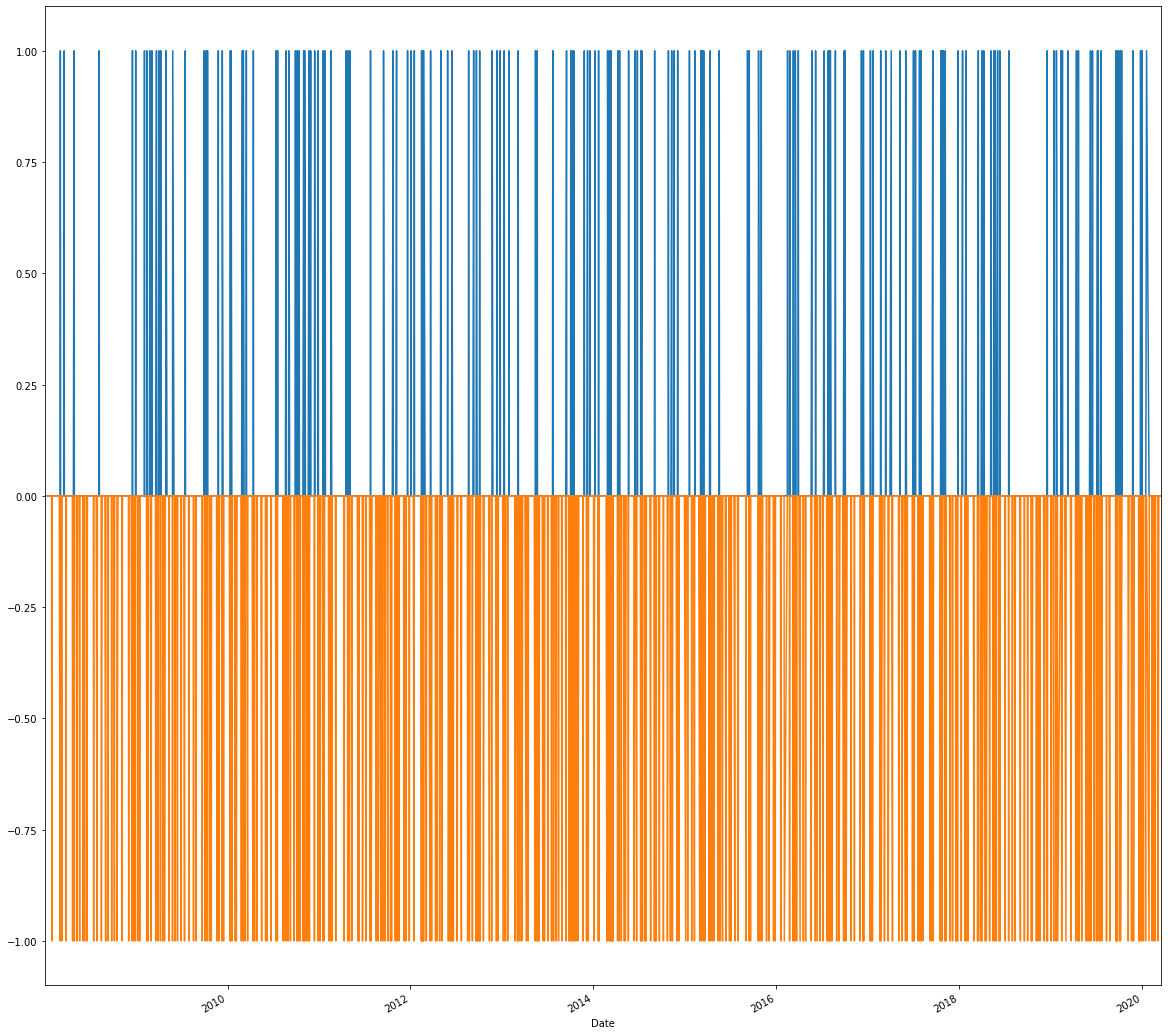

In [401]:
(buy*1).plot()
(sell*-1).plot()

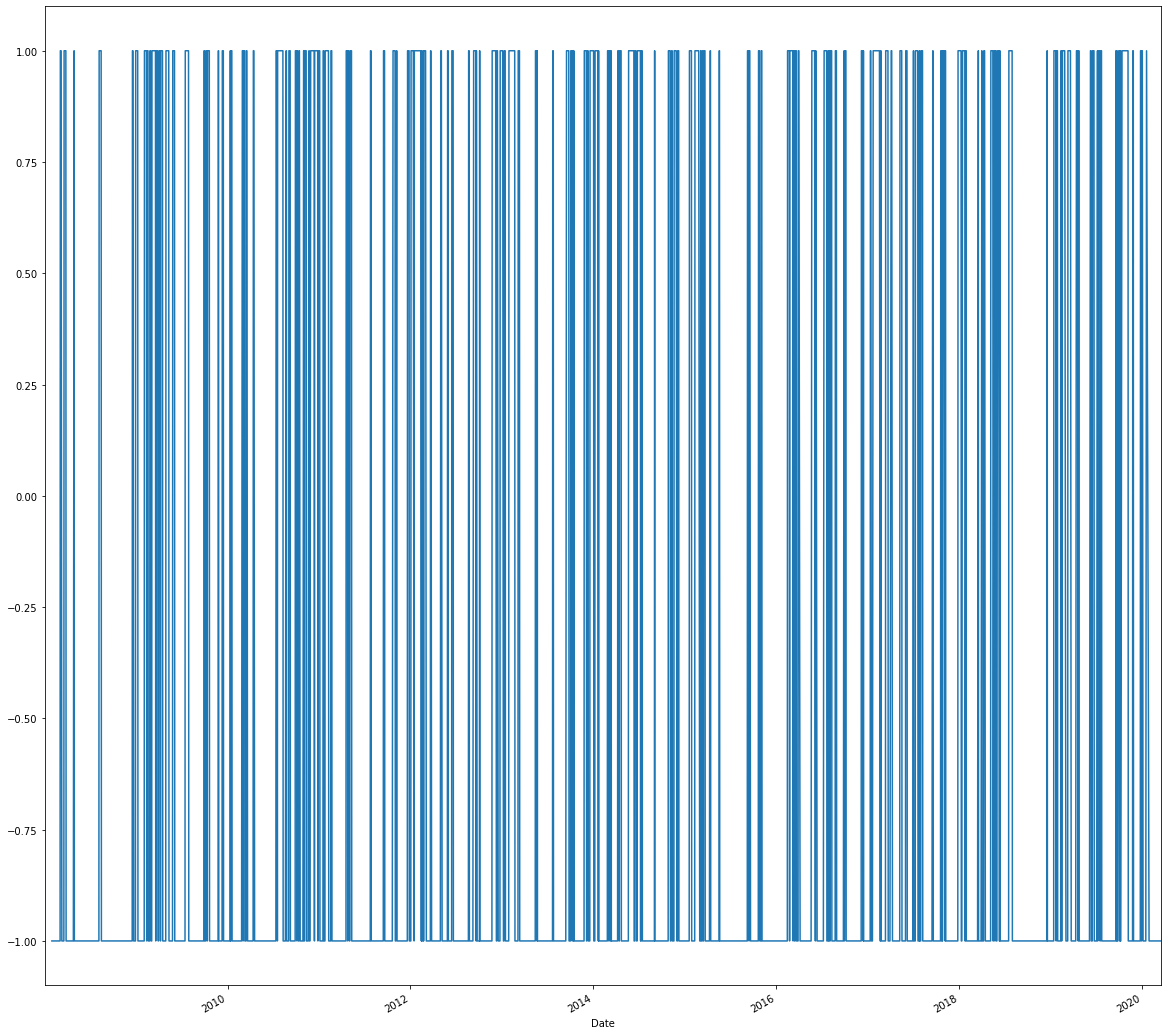

In [402]:
import numpy as np
hold = pd.Series(np.nan, index=buy.index)
hold[buy] = 1
hold[sell] = -1
hold.ffill(inplace=True)
hold.plot()

In [225]:
import io
def crawl_price(stock_id):
    now = int(datetime.now().timestamp())+86400
    url = "https://query1.finance.yahoo.com/v7/finance/download/" + stock_id + "?period1=0&period2=" + str(now) + "&interval=1d&events=history&crumb=hP2rOschxO0"
    response = requests.get(url)
    f = io.StringIO(response.text)
    df = pd.read_csv(f, index_col='Date', parse_dates=['Date'] )
    return df

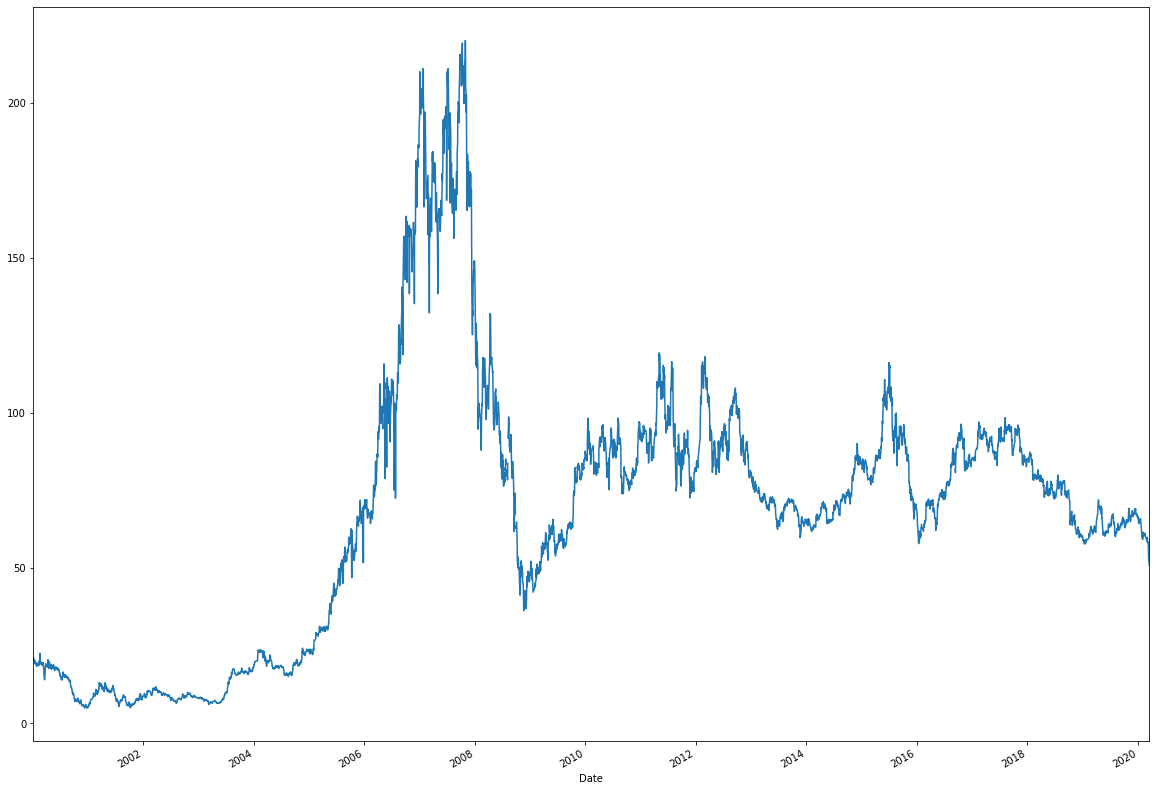

In [226]:
df = crawl_price("2354.TW")
df.Close.plot()

In [227]:
url = "https://finance.yahoo.com/world-indices/"
response = requests.get(url)

import io
f = io.StringIO(response.text)
dfs = pd.read_html(f)
world_index = dfs[0]

,Symbol,Name,Last Price,Change,% Change,Volume,Intraday High/Low,52 Week Range,Day Chart
0,^GSPC,S&P 500,2490.33,+104.20,+4.37%,1.686B,NaN,NaN,NaN
1,^DJI,Dow 30,20761.78,+573.26,+2.84%,304.186M,NaN,NaN,NaN
2,^IXIC,Nasdaq,7224.91,+320.32,+4.64%,1.284B,NaN,NaN,NaN
3,^NYA,NYSE COMPOSITE (DJ),9926.48,+358.95,+3.75%,0,NaN,NaN,NaN
4,^XAX,NYSE AMEX COMPOSITE INDEX,1520.68,+21.53,+1.44%,0,NaN,NaN,NaN
5,^BUK100P,Cboe UK 100 Price Return,8865.83,+200.97,+2.32%,0,NaN,NaN,NaN
6,^RUT,Russell 2000,1063.45,+26.03,+2.51%,0,NaN,NaN,NaN
7,^VIX,Vix,74.12,-8.57,-10.36%,0,NaN,NaN,NaN
8,^FTSE,FTSE 100,5210.45,+59.37,+1.15%,0,NaN,NaN,NaN
9,^GDAXI,DAX PERFORMANCE-INDEX,8955.44,+213.19,+2.44%,0,NaN,NaN,NaN


In [228]:
import time
world_index_history = {}
for symbol, name in zip(world_index['Symbol'], world_index['Name']):
    
    print(name)
    
    world_index_history[name] = crawl_price(symbol)
    time.sleep(5)

S&P 500
Dow 30
Nasdaq
NYSE COMPOSITE (DJ)
NYSE AMEX COMPOSITE INDEX
Cboe UK 100 Price Return
Russell 2000
Vix
FTSE 100
DAX PERFORMANCE-INDEX
CAC 40
ESTX 50 PR.EUR
EURONEXT 100
BEL 20
MOEX Russia Index
Nikkei 225
HANG SENG INDEX
SSE Composite Index
STI Index
S&P/ASX 200
ALL ORDINARIES
S&P BSE SENSEX
Jakarta Composite Index
FTSE Bursa Malaysia KLCI
S&P/NZX 50 INDEX GROSS
KOSPI Composite Index
TSEC weighted index
S&P/TSX Composite index
IBOVESPA
IPC MEXICO
S&P/CLX IPSA
MERVAL
TA-125
EGX 30 Price Return Index
Top 40 USD Net TRI Index


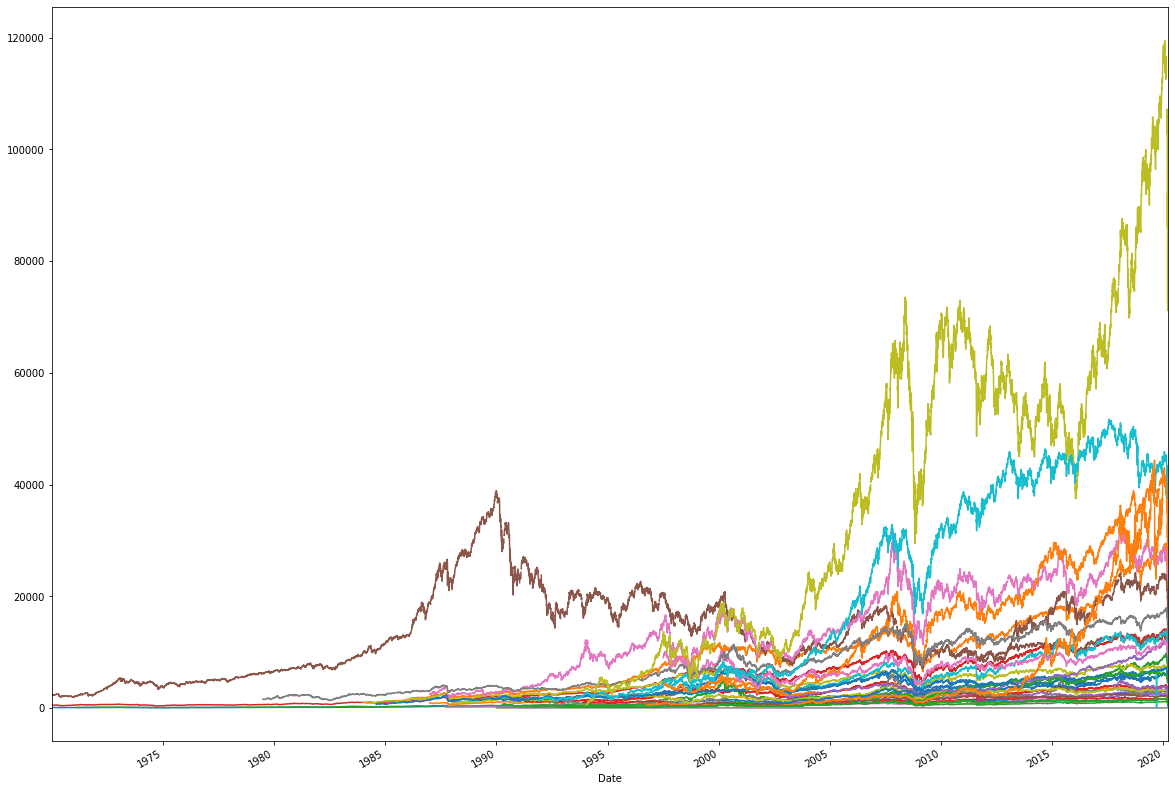

In [229]:
for name, history in world_index_history.items():
    history.Close.plot()

In [279]:
print(world_index_history['TSEC weighted index']['2008-01':][['Adj Close','Volume']])

               Adj Close     Volume
Date                               
2008-01-02   8323.017578  4372600.0
2008-01-03   8184.169434  3636400.0
2008-01-04   8221.067383  4603600.0
2008-01-07   7883.339844  4539800.0
2008-01-08   7962.879883  4618800.0
...                  ...        ...
2020-03-11  10893.750000  2804700.0
2020-03-12  10422.320313  4844200.0
2020-03-13  10128.870117  5906200.0
2020-03-16   9717.769531  3783600.0
2020-03-17   9439.629883        0.0

[3007 rows x 2 columns]


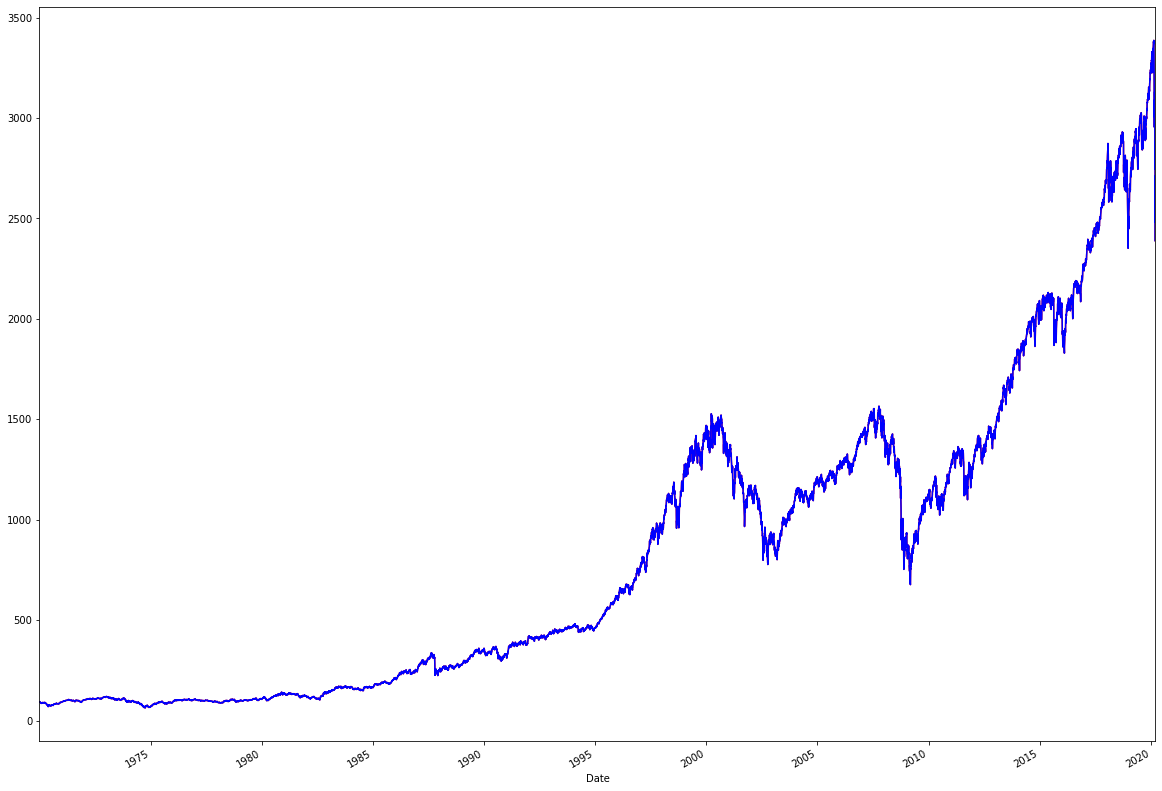

In [231]:
sp500 = world_index_history['S&P 500']
sp500['Close'].plot(color='red')
sp500['Adj Close'].plot(color='blue')

In [232]:
adjclose = {}
for name, price in world_index_history.items():
    if price.index.is_unique:
        adjclose[name] = price['Adj Close']
    
adjclose = pd.DataFrame(adjclose)
adjclose

,S&P 500,Dow 30,Nasdaq,NYSE COMPOSITE (DJ),NYSE AMEX COMPOSITE INDEX,Cboe UK 100 Price Return,Russell 2000,Vix,FTSE 100,DAX PERFORMANCE-INDEX,...,KOSPI Composite Index,TSEC weighted index,S&P/TSX Composite index,IBOVESPA,IPC MEXICO,S&P/CLX IPSA,MERVAL,TA-125,EGX 30 Price Return Index,Top 40 USD Net TRI Index
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-02,93.000000,NaN,NaN,550.890015,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,93.459999,NaN,NaN,553.640015,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-06,92.820000,NaN,NaN,549.830017,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-07,92.629997,NaN,NaN,548.989990,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-08,92.680000,NaN,NaN,549.409973,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-12,2480.639893,21200.619141,7201.799805,10060.759766,1564.900024,8969.780273,1122.930054,75.470001,5237.500000,9161.129883,...,1834.329956,10422.320313,12508.500000,72583.000000,36636.699219,NaN,28351.890625,1201.030029,NaN,2569.000000
2020-03-13,2711.020020,23185.619141,7874.879883,10851.740234,1602.250000,9016.780273,1210.130005,57.830002,5366.100098,9232.080078,...,1771.439941,10128.870117,13716.299805,82678.000000,38085.050781,NaN,28447.970703,NaN,NaN,2594.739990
2020-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [242]:
pct_change = adjclose.pct_change()
profit = pct_change.mean()
profit.sort_values()

Top 40 USD Net TRI Index    -0.000519
Cboe UK 100 Price Return     0.000018
EURONEXT 100                 0.000026
TSEC weighted index          0.000082
FTSE Bursa Malaysia KLCI     0.000088
BEL 20                       0.000135
STI Index                    0.000169
ESTX 50 PR.EUR               0.000174
NYSE AMEX COMPOSITE INDEX    0.000183
FTSE 100                     0.000203
Nikkei 225                   0.000207
S&P/TSX Composite index      0.000212
KOSPI Composite Index        0.000227
ALL ORDINARIES               0.000228
MOEX Russia Index            0.000242
NYSE COMPOSITE (DJ)          0.000246
Russell 2000                 0.000257
S&P 500                      0.000277
TA-125                       0.000287
Jakarta Composite Index      0.000290
S&P/CLX IPSA                 0.000291
DAX PERFORMANCE-INDEX        0.000303
S&P/NZX 50 INDEX GROSS       0.000314
Dow 30                       0.000316
HANG SENG INDEX              0.000327
S&P BSE SENSEX               0.000364
Nasdaq      

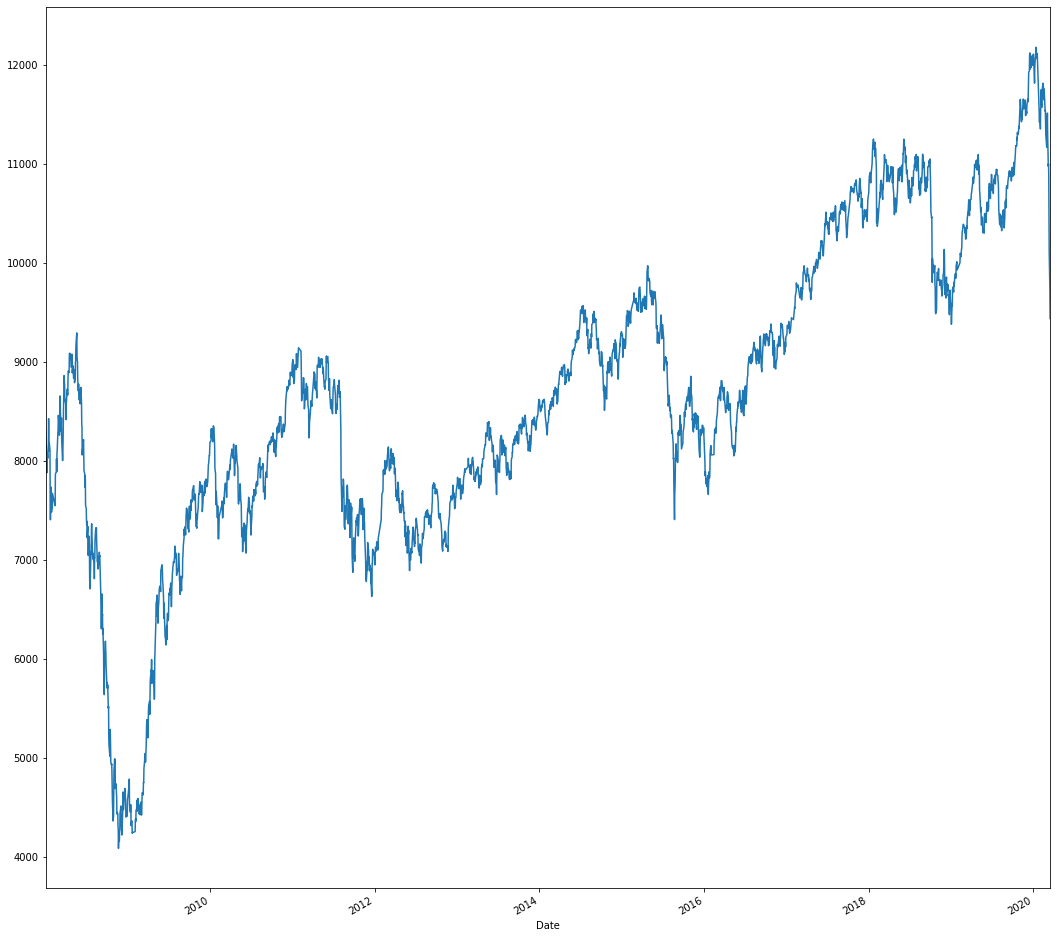

In [271]:
adjclose['TSEC weighted index']['2008-01':].dropna().plot()

In [403]:
pct_change = df['close'].pct_change()
profit = pct_change.rolling(252).mean()
risk = pct_change.rolling(252).std()
sharpe = profit / risk * (252 ** 0.5)

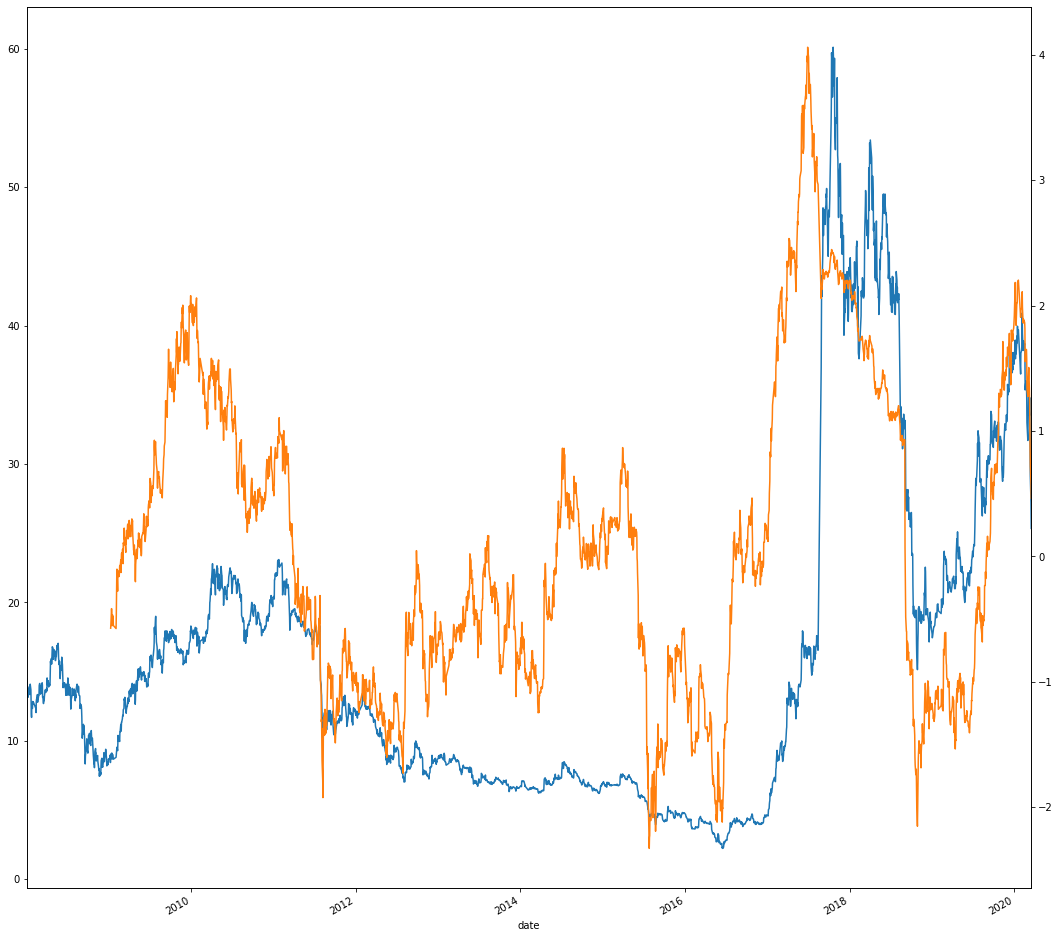

In [253]:
df["close"].plot()
sharpe.plot(secondary_y = True)

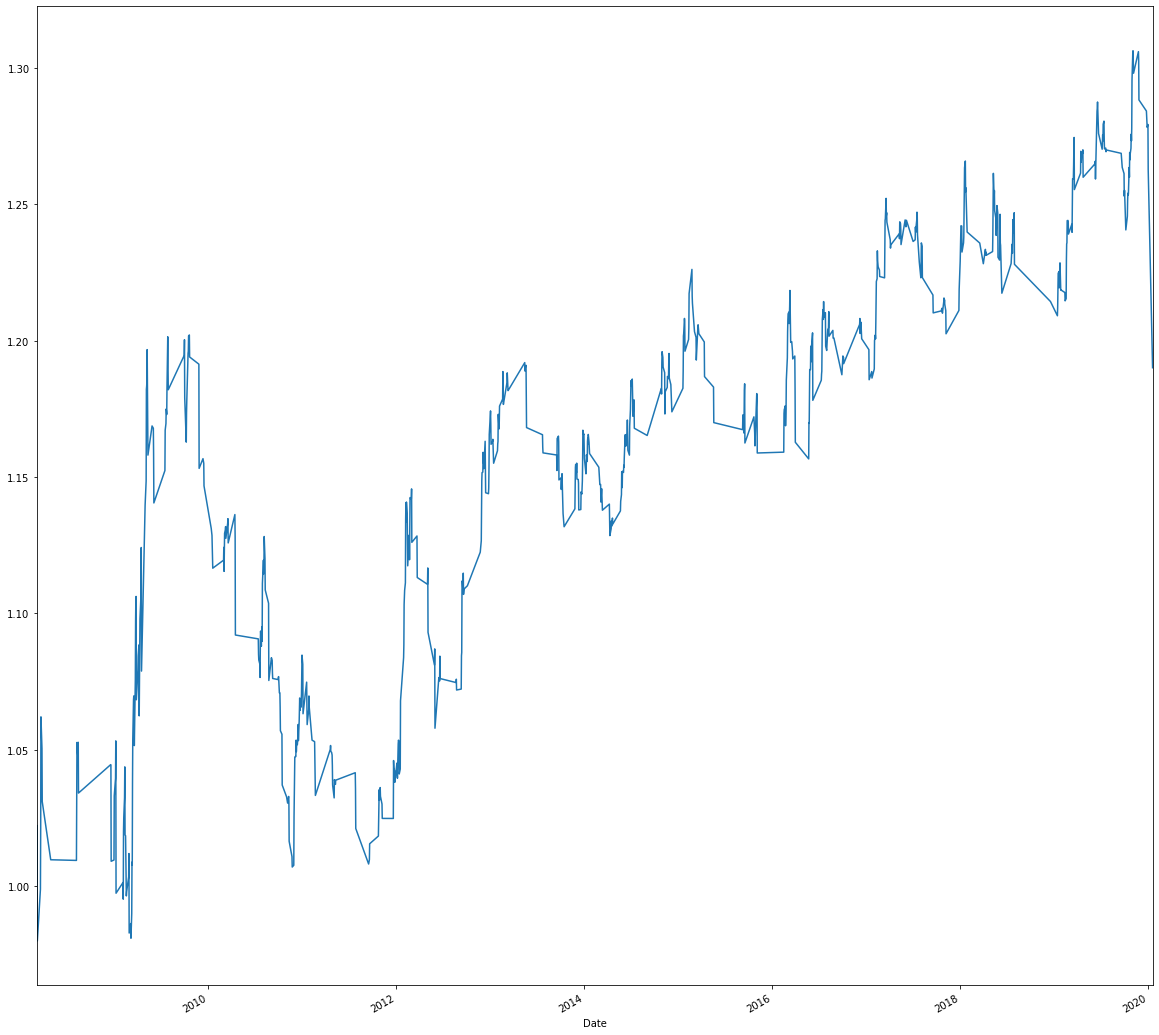

In [404]:

#twii = df['close'][buy.index]

pct_change = df['close'].pct_change()
pct_ratio = (pct_change.shift(-1)+1) # 今天到明天的價格變化

pct_ratio.fillna(1)[hold == 1].cumprod().plot()

In [264]:
for k,v in pct_ratio.fillna(1)[hold == 1].cumprod().items():
    if v > 1:
        print(k)

2008-02-26 00:00:00
2008-02-27 00:00:00
2008-02-29 00:00:00
2008-03-03 00:00:00
2008-03-06 00:00:00
2008-03-07 00:00:00
2008-03-10 00:00:00
2008-03-11 00:00:00
2008-04-01 00:00:00
2008-04-03 00:00:00
2008-04-15 00:00:00
2008-04-16 00:00:00
2008-04-17 00:00:00
2008-04-18 00:00:00
2008-04-21 00:00:00
2008-04-23 00:00:00
2008-04-24 00:00:00
2008-04-25 00:00:00
2008-04-28 00:00:00
2008-07-02 00:00:00
2008-07-03 00:00:00
2008-07-04 00:00:00
2008-07-07 00:00:00
2008-07-08 00:00:00
2008-07-09 00:00:00
2008-07-10 00:00:00
2008-07-11 00:00:00
2008-07-14 00:00:00
2008-10-02 00:00:00
2008-10-03 00:00:00
2008-10-06 00:00:00
2008-10-07 00:00:00
2008-11-27 00:00:00
2008-11-28 00:00:00
2008-12-01 00:00:00
2008-12-02 00:00:00
2008-12-08 00:00:00
2008-12-09 00:00:00
2008-12-10 00:00:00
2008-12-11 00:00:00
2008-12-17 00:00:00
2008-12-18 00:00:00
2009-02-20 00:00:00
2009-02-25 00:00:00
2009-02-26 00:00:00
2009-02-27 00:00:00
2009-03-02 00:00:00
2009-03-03 00:00:00
2009-03-04 00:00:00
2009-03-05 00:00:00
